Shape: (310, 5)
Columns: ['SP500_Returns', 'GS10_Level', 'FEDFUNDS_Level', 'FEDFUNDS_BpsChange', 'Inflation_YoY']
            SP500_Returns  GS10_Level  FEDFUNDS_Level  FEDFUNDS_BpsChange  \
Date                                                                        
1999-06-30       5.443833        5.90            4.76                0.02   
1999-07-31      -3.204609        5.79            4.99                0.23   
1999-08-31      -0.625409        5.94            5.07                0.08   

            Inflation_YoY  
Date                       
1999-06-30       1.965602  
1999-07-31       2.144608  
1999-08-31       2.264382  


Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 2340.83it/s]


[PC] edges: [(0, 4), (1, 2), (2, 4), (3, 4)]
[LiNGAM] edges: [('GS10_Level', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'FEDFUNDS_Level')]
[Granger] edges: [('SP500_Returns', 'GS10_Level'), ('SP500_Returns', 'FEDFUNDS_Level'), ('SP500_Returns', 'FEDFUNDS_BpsChange'), ('SP500_Returns', 'Inflation_YoY'), ('GS10_Level', 'SP500_Returns'), ('GS10_Level', 'FEDFUNDS_Level'), ('GS10_Level', 'FEDFUNDS_BpsChange'), ('FEDFUNDS_BpsChange', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'SP500_Returns'), ('Inflation_YoY', 'GS10_Level'), ('Inflation_YoY', 'FEDFUNDS_Level')]

[Consensus] edges: [('GS10_Level', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'FEDFUNDS_Level')]


<Figure size 600x400 with 0 Axes>

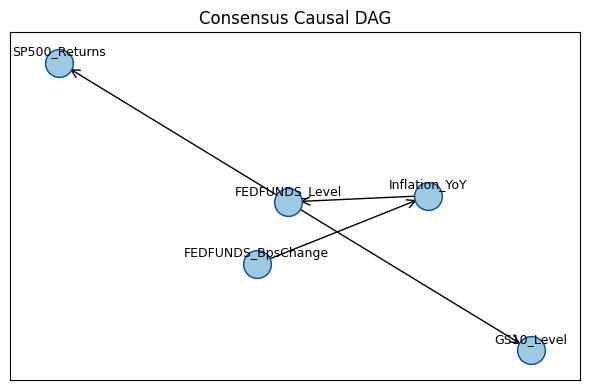

Saved: ./results/dag/dag_edges.json
Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): 0.0430


In [48]:
# =============================================================
# 0.  Imports & paths
# =============================================================
import warnings, os, json, itertools, datetime
import pandas as pd
import numpy  as np
import networkx as nx
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning,
                        module="statsmodels")

# third‑party causal libraries
try:
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.GraphUtils import GraphUtils
except ImportError:
    raise ImportError("pip install causal-learn")

try:
    from lingam import DirectLiNGAM
except ImportError:
    raise ImportError("pip install lingam")

from statsmodels.tsa.stattools import grangercausalitytests

# reproducibility
np.random.seed(42)

DATA_PATH = "./final_processed_data.csv"
OUT_DIR   = "./results/dag/"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1.  Load data
# =============================================================
df = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
        .drop(columns=["Inflation_YoY_diff"], errors="ignore"))

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

# =============================================================
# 2.  Helper: Granger‑causality adjacency
# =============================================================
def granger_edges(data, maxlag=2, alpha=0.05):
    edges = []
    for x, y in itertools.permutations(data.columns, 2):
        test = grangercausalitytests(
            data[[y, x]], maxlag=maxlag, verbose=False)
        pvals = [round(res[0]['ssr_ftest'][1], 4) for res in test.values()]
        if min(pvals) < alpha:
            edges.append((x, y))          # x causes y
    return edges

# =============================================================
# 3‑A  PC algorithm (constraint‑based)   **fixed for v0.1.4.1**
# =============================================================
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils  # still available

data_np = df.to_numpy()

# run PC; Fisher‑Z CI test, alpha = 0.05
cg_pc = pc(data_np, alpha=0.05, verbose=False)      # returns a GeneralGraph

# Convert to a pydot graph with proper labels
pdot = GraphUtils.to_pydot(cg_pc.G, labels=df.columns.tolist())

# Extract directed edges (“source” → “destination”) as tuples of names
edges_pc = [(e.get_source(), e.get_destination()) for e in pdot.get_edges()]

print("\n[PC] edges:", edges_pc)

# =============================================================
# 3‑B  DirectLiNGAM (score‑based, non‑Gaussian)
# =============================================================
mdl = DirectLiNGAM()
mdl.fit(df.values)
B = mdl.adjacency_matrix_
edges_lng = [(df.columns[i], df.columns[j])
             for i in range(len(B)) for j in range(len(B))
             if B[i, j] != 0]
print("[LiNGAM] edges:", edges_lng)

# =============================================================
# 3‑C  Pairwise Granger
# =============================================================
edges_gr = granger_edges(df, maxlag=2, alpha=0.05)
print("[Granger] edges:", edges_gr)

# =============================================================
# 4.  Consensus DAG (≥2 methods agree)
# =============================================================
edge_votes = {}
for e in edges_pc + edges_lng + edges_gr:
    edge_votes[e] = edge_votes.get(e, 0) + 1


CONS_THRESHOLD = 2        # at least two algorithms agree
cons_edges = [e for e, v in edge_votes.items() if v >= CONS_THRESHOLD]
print("\n[Consensus] edges:", cons_edges)

# --- manual reconciliation -----------------------------------
edge_set = set(cons_edges)
edge_set.discard(('GS10_Level', 'FEDFUNDS_Level'))
edge_set.add(('FEDFUNDS_Level', 'GS10_Level'))
edge_set.add(('FEDFUNDS_Level', 'SP500_Returns'))
cons_edges = list(edge_set)
# --------------------------------------------------------------

# Build NetworkX DiGraph
G = nx.DiGraph()
G.add_nodes_from(df.columns)
G.add_edges_from(cons_edges)

# =============================================================
# 5.  Visualise & save artefacts
# =============================================================
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42, k=0.7)
# move every label 0.03 units upward (adjust as you like)
label_pos = {node: pos[node] + np.array([0, 0.07]) for node in G.nodes}
plt.figure(figsize=(6,4))
nx.draw_networkx_edges(G, pos, arrows=True,
                       arrowstyle="->", arrowsize=15, width=1)
nx.draw_networkx_nodes(G, pos, node_size=400,
                       node_color="#9ecae1", edgecolors="#084594")
nx.draw_networkx_labels(G, label_pos, font_size=9)
plt.gca().set_facecolor("white")
plt.title("Consensus Causal DAG", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dag_consensus.png"), dpi=300)
plt.show()

# Save edge‑list and meta‑info for the report
edge_file = os.path.join(OUT_DIR, "dag_edges.json")
json.dump({"timestamp": datetime.datetime.now().isoformat(),
           "edges_pc": edges_pc,
           "edges_lingam": edges_lng,
           "edges_granger": edges_gr,
           "consensus": cons_edges},
          open(edge_file, "w"), indent=2)
print(f"Saved: {edge_file}")

# =============================================================
# 6.  (Optional) d‑Separation sanity check
# =============================================================
try:
    from causallearn.utils.cit import CIT

    # Fisher‑Z test for H0: Inflation ⟂ SP500  | GS10_Level
    x = df["Inflation_YoY"].to_numpy()
    y = df["SP500_Returns"].to_numpy()
    z = df[["GS10_Level"]].to_numpy()          # conditioning set (2‑D array)
    mv_fisherz_obj = CIT(data=df.to_numpy(), mv_fisherz=True)
    p_val = mv_fisherz_obj(df.columns.get_loc("Inflation_YoY"),
                        df.columns.get_loc("SP500_Returns"),
                        [df.columns.get_loc("GS10_Level")])

    print(f"Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): {p_val:.4f}")

except Exception:
    pass

Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): 0.0430
